<a href="https://colab.research.google.com/github/lillianpoland/hi-class/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
#load the data from Mr. A's github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [3]:
#print a the begining and end of the raw data set, as a pandas dataframe
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


In [4]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [5]:
#print the dataframe wiht the new column
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [6]:
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [7]:
 #Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [8]:
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [9]:
with pm.Model(coords=aa_coords) as cs_nh_model:
   μ = pm.StudentT('μ', nu=3, mu=0, sigma=10, dims="aa")
   σ = pm.HalfStudentT('σ', nu=3, sigma=10, dims="aa")
   y = pm.StudentT('y', nu=3, mu=μ[aa_idx], sigma=σ[aa_idx], observed=cs_data['diff_TminusE'])
   idata_cs_nh = pm.sample()

Output()

Output()

array([<Axes: >], dtype=object)

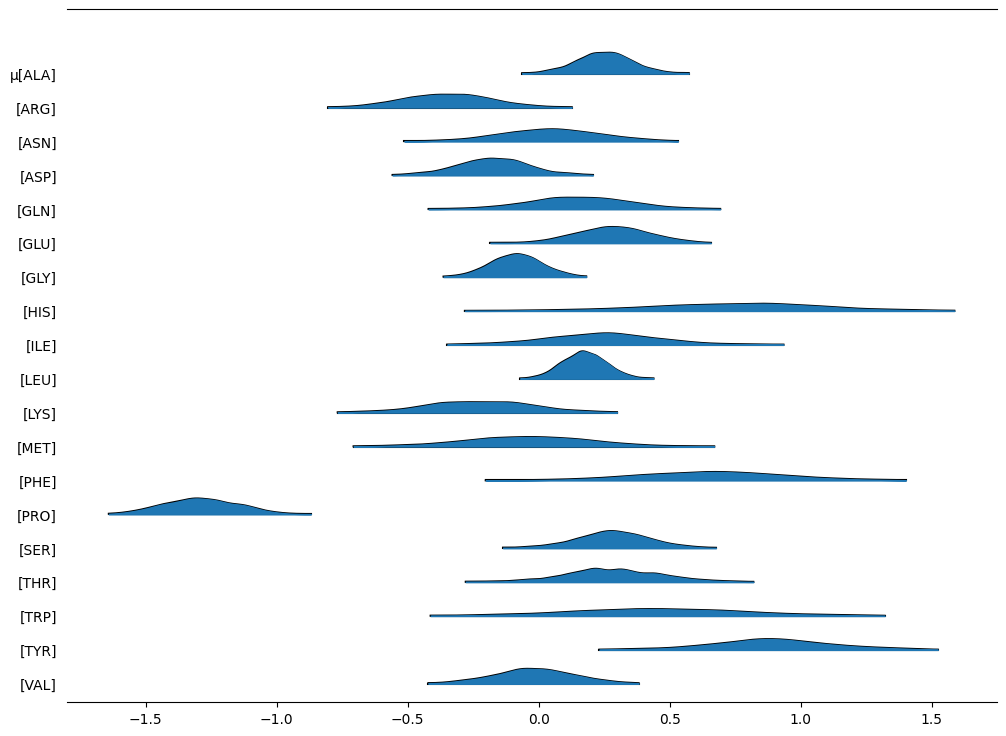

In [10]:
#The ridge plot shows the distribution of different groups
az.plot_forest(idata_cs_nh, kind="ridgeplot", var_names='μ', combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [11]:
with pm.Model(coords=aa_coords) as cs_model:
    μ = pm.Normal('μ', mu=0, sigma=10, dims="aa")
    σ = pm.HalfNormal('σ', sigma=10, dims="aa")
    y = pm.Normal('y', mu=μ[aa_idx], sigma=σ[aa_idx], observed=cs_data['diff_TminusE'])
    idata_cs = pm.sample()

posterior_predictive_normal = pm.sample_posterior_predictive(idata_cs, model=cs_model)

Output()

Output()

Output()

In [12]:
posterior_predictive_studentt = pm.sample_posterior_predictive(idata_cs_nh, model=cs_nh_model)

Output()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


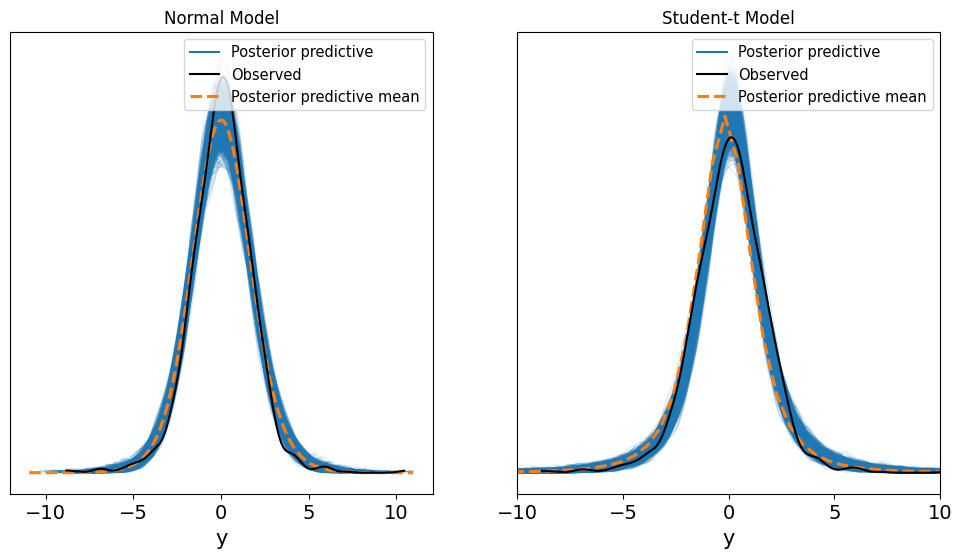

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

az.plot_ppc(posterior_predictive_normal, ax=ax[0])
ax[0].set_title("Normal Model")

az.plot_ppc(posterior_predictive_studentt, ax=ax[1])
ax[1].set_title("Student-t Model")
ax[1].set_xlim([-10, 10])  # X-axis range is specified so it is comparable to the Normal Model
#allows us to analyze the differences

plt.show()

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [14]:
#load the data from Mr. A's github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [15]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [16]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [17]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

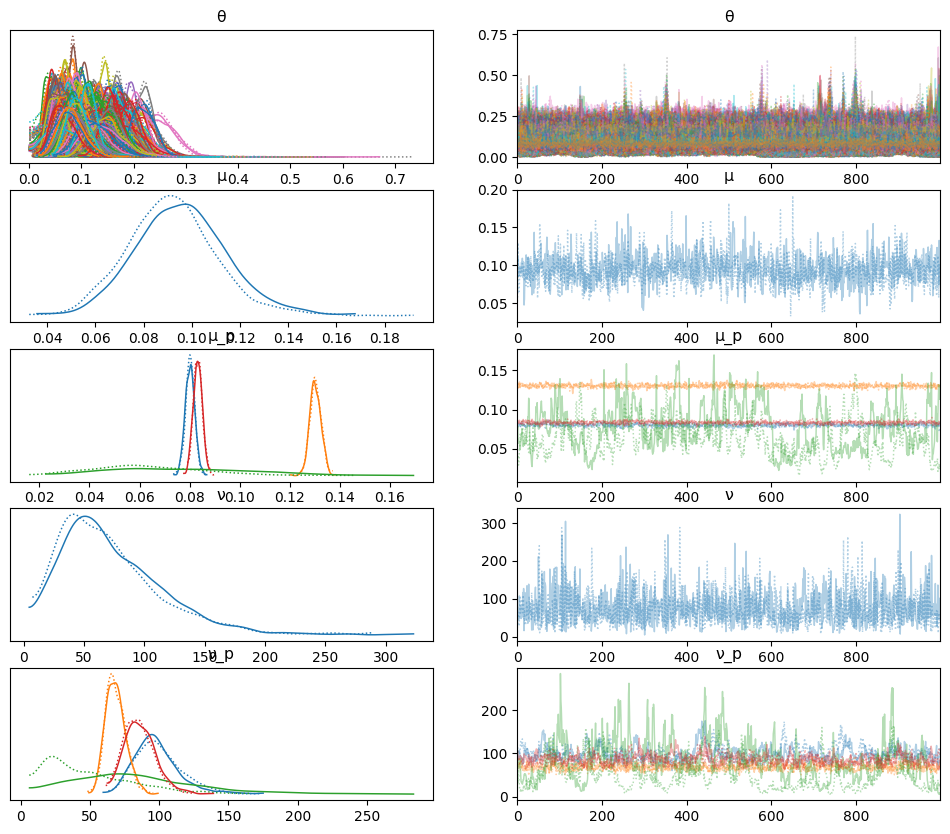

In [19]:
az.plot_trace(idata_sccr)

In [20]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.001 1.001 ... 1.001 1.003 0.9996
    μ        float64 8B 1.009
    μ_p      (pos) float64 32B 1.002 1.002 1.079 1.005
    ν        float64 8B 1.001
    ν_p      (pos) float64 32B 1.007 1.001 1.177 1.01

When I compared the hierarchical and non-hierarchical model for theta in the trace plot, I noticed a clear difference in stability. My plot had more pronounced peaks, showing more variation, while the hierarchical model had a more smooth distribution. This is probably because the hierarchical model tends to pool information across groups, which smooths out the individual fluctuations, whereas the non-hierarchical shows each group's behavior independently. Theta had values right below 1, while I had values right above 1. For the rhat, I noticed that my model had a value for μ_p that was closer to 1, imdicating better convergence than the model in the notes. However, the v_p model in the notes was closer to one, indicating the notes' model had better convergence.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

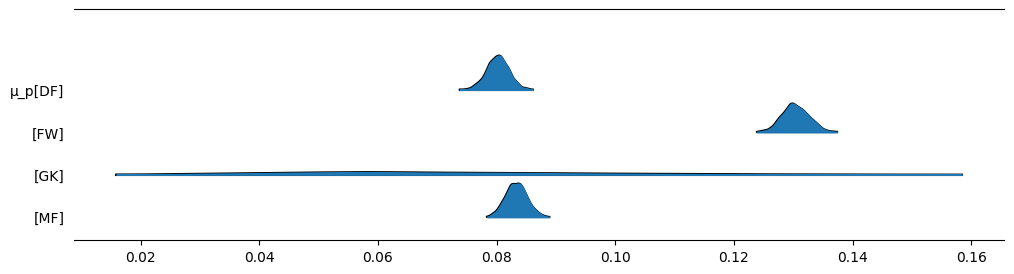

In [21]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

My range is a lot smaller than the hierarchical model from class.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [22]:
filtered_sccr_data = sccr_data[sccr_data['position'] != 'GK']

In [23]:
pos_idx = filtered_sccr_data.position.cat.codes.values
pos_codes = filtered_sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [24]:
with pm.Model(coords=sccr_coords) as sccr_no_gk_model:
       # Hyperpriors
       μ_μ = pm.Beta('μ_μ', alpha=2, beta=20)
       ν_μ = pm.Gamma('ν_μ', mu=55, sigma=45)

       # Priors
       μ_p = pm.Beta('μ_p', alpha=μ_μ, beta=(1 - μ_μ) * ν_μ, dims="pos")
       ν_p = pm.Gamma('ν_p', mu=ν_μ, sigma=45, dims="pos")

       # Parameter for players
       θ = pm.Beta('θ', mu=μ_p[pos_idx], nu=ν_p[pos_idx])

       # Likelihood
       _ = pm.Binomial('gs',
                       n=filtered_sccr_data.shots.values,
                       p=θ,
                       observed=filtered_sccr_data.goals.values)

       # Sample
       idata_sccr_no_gk = pm.sample(target_accept=0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'μ_μ'}>, <Axes: title={'center': 'μ_μ'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>],
       [<Axes: title={'center': 'ν_μ'}>, <Axes: title={'center': 'ν_μ'}>]],
      dtype=object)

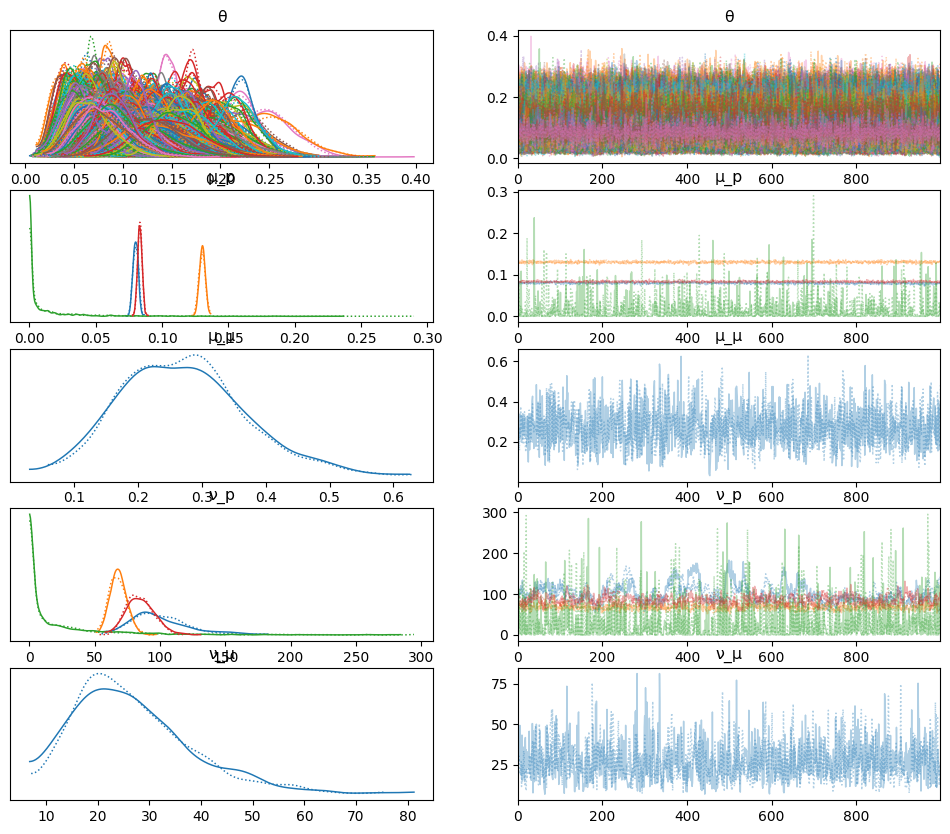

In [25]:
az.plot_trace(idata_sccr_no_gk)

In [26]:
az.rhat(idata_sccr_no_gk)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.0 1.002 1.001 ... 0.9994 1.001 1.001
    μ_p      (pos) float64 32B 1.017 1.004 1.006 1.001
    μ_μ      float64 8B 1.002
    ν_p      (pos) float64 32B 1.035 1.005 1.004 1.007
    ν_μ      float64 8B 1.003

The model without goalkeepers seems to be more manageable for PyMC, probably because there is less data, which requires less processing. Excluding goalkeepers also resulted in a more normally distributed graph, without that peak from the original dataset. However, by removing the goalkeepers, the visual representation of the dataset was changed, again due to the lack of a peak. This adjustment could be good for us if our focus was on players other than goalkeepers. But if we are trying to look at the soccer team as a whole, excluding the goalkeepers prevents that from happening. The choice depends on the specific analysis goals you have.